In [1]:
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing required libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader 
import pathlib
import glob
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import flatten
import torchvision.models as models
import time
import copy

In [3]:
from google.colab import files

### Mounting Drive in Google colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Extracting zip file of Naturalist dataset

In [5]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/nature_12K.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/nature') #Extracts the files into the /nature folder
zip_ref.close()

### launching Cuda

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
### Defining some variabels
data_dir='/nature/inaturalist_12K'
model_name="ResNet50"
batch_size=64
num_classes=10
feature_extract=True
num_epoch=15
input_size=224

### **defining transformation for augmenting the image**

In [8]:
train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(input_size),
                                       transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomAffine(degrees=0,scale=(0.3,1)),
                                       transforms.ToTensor(),
                                       
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                      transforms.RandomResizedCrop(input_size),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### **Loading the data through data loader**

In [9]:
train_data = torchvision.datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(data_dir + '/val', transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True,num_workers=2)
train_step=len(train_loader) ### this will return total data in train_sampler//batch_size(8000/128=63)
val_step=len(test_loader)

### **Function for training the model with transfer learning on our Naturalist  dataset**

In [10]:
def train(model,loss,optimizer,scheduler,num_epoch):
  ## model -->ResNet50 our pre-trained model
  # loss-->Cross-entrophy loss
  # optimizer->> SGD with momentum
  # scheduler--> leraning rate scheduler
  # num_epoch --> num of epoches

  since=time.time() ## for tracking the time
  model_wts=copy.deepcopy(model.state_dict())  ## here copying the weights of pre-trained model
  best_accuracy=0
  ##  list for storing loss and accuracy
  train_Loss=[]
  train_Acc=[]
  val_Loss=[]
  val_Acc=[]
  for epoch in range(num_epoch):
    
    model.train()  ## for keeping model in training mode
    train_accuracy=0.0
    train_loss=0.0
    for i,(images,labels) in enumerate(train_loader):
      images=images.to(device)
      labels=labels.to(device)
      optimizer.zero_grad()
      outputs=model(images)
      loss=loss_fun(outputs,labels)
      
    #print(loss)
      loss.backward()
      optimizer.step()
      train_loss+=(loss.item())/batch_size  
      scores,prediction=torch.max(outputs.data,1)
      train_accuracy+=int(torch.sum(prediction==labels.data))
    scheduler.step()
    train_accuracy=(train_accuracy/(train_step*batch_size))*100
    train_Acc.append(train_accuracy)
    train_loss=(train_loss/train_step)*100
    train_Loss.append(train_loss)


    model.eval()         ## for kepping model in evalution mode
    with torch.no_grad():
      val_accuracy=0.0
      val_loss=0
      for i,(images,labels) in enumerate(test_loader):
        # if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
        
        outputs=model(images)
        loss=loss_fun(outputs,labels)
        val_loss+=(loss.item())/batch_size
        scores,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
    
    val_accuracy=(val_accuracy/(val_step*batch_size))*100
    val_Acc.append(val_accuracy)
    val_loss=(val_loss/val_step)*100
    val_Loss.append(val_loss)
    print('Epoch:'+str(epoch)+' Train Loss:'+str(float(train_loss))+' Train accuracy'+str(train_accuracy)+' val_accuracy'+str(val_accuracy))
  
    if val_accuracy>best_accuracy:
      # torch.save(model.state_dict(),'best_checkpoint.model')
      best_accuracy=val_accuracy
      model_wts=copy.deepcopy(model.state_dict())
  plt.plot(train_Loss, 'r', label="Training loss")
  plt.plot(val_Loss, 'lime', label="Validation loss")
  plt.title("Training and Validation Loss vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Loss", size=15)
  plt.legend()
  plt.show()

  plt.plot(train_Acc, 'r', label="Training Accuracy")
  plt.plot(val_Acc ,'lime', label="Validation Accuracy")
  plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Accuracy", size=15)
  plt.legend()
  plt.show()   

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_accuracy:4f}')
  model.load_state_dict(model_wts)
  return model


In [ ]:
## Fintuning the convolution network

### ***Fine-tuning the ResNet50 NN by redefing the last layer for 10 classes***



In [ ]:
model=models.resnet50(pretrained=True)

model.fc=nn.Linear(model.fc.in_features,10)  ## redefining the last layers for 10 classes
model.fc.requires_grad=True
model=model.to(device)
loss_fun=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 300MB/s]


In [ ]:
print(model) # analyzing the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch:0 Train Loss:1.9058046399787734 Train accuracy62.51990445859873 val_accuracy75.0
Epoch:1 Train Loss:1.0731453339978578 Train accuracy77.2890127388535 val_accuracy77.24609375
Epoch:2 Train Loss:0.9191272910802987 Train accuracy80.67277070063695 val_accuracy78.955078125
Epoch:3 Train Loss:0.8162314493422674 Train accuracy81.94665605095541 val_accuracy79.19921875
Epoch:4 Train Loss:0.7421247631453785 Train accuracy84.36504777070064 val_accuracy79.150390625
Epoch:5 Train Loss:0.6886788451106874 Train accuracy85.24084394904459 val_accuracy79.19921875
Epoch:6 Train Loss:0.6450173046119558 Train accuracy85.64888535031847 val_accuracy79.931640625
Epoch:7 Train Loss:0.6190448045837367 Train accuracy86.72372611464968 val_accuracy80.615234375
Epoch:8 Train Loss:0.6258755556017065 Train accuracy86.54458598726114 val_accuracy80.517578125
Epoch:9 Train Loss:0.5999704327576669 Train accuracy87.02229299363057 val_accuracy81.298828125
Epoch:10 Train Loss:0.5926586416176266 Train accuracy86.833200

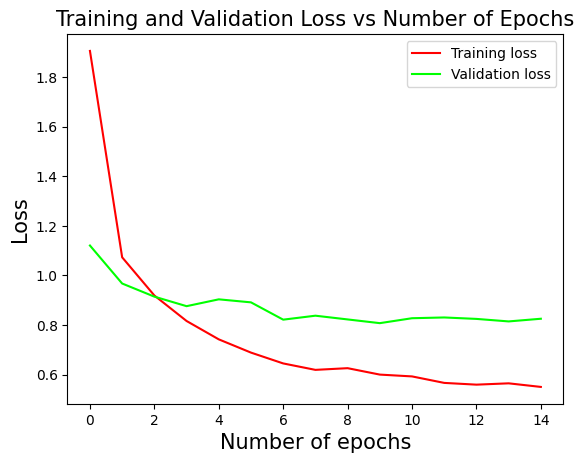

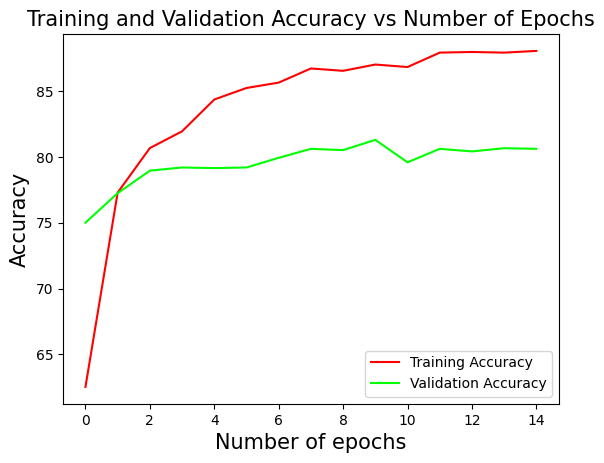

Training complete in 49m 50s
Best val Acc: 81.298828


In [ ]:
model=train(model,loss_fun,optimizer,lr_scheduler,num_epoch)

### **Doing Fixed feature exractor by Freezing all Layers except last fully connected  layer,means we are updating the parameter of last layer only.**

In [ ]:
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
model=models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc=nn.Linear(model.fc.in_features,10)  ## redefining the last layers for 10 classes
model=model.to(device)
loss_fun=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(model.fc.parameters(),lr=0.001,momentum=0.9) ##only last layer parameters is optimize
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


Epoch:0 Train Loss:2.286144244561719 Train accuracy58.09116242038217 val_accuracy70.751953125
Epoch:1 Train Loss:1.476417413681366 Train accuracy71.61624203821655 val_accuracy71.923828125
Epoch:2 Train Loss:1.333935906410597 Train accuracy72.66122611464968 val_accuracy72.998046875
Epoch:3 Train Loss:1.2538144987812088 Train accuracy74.19386942675159 val_accuracy74.560546875
Epoch:4 Train Loss:1.2063893026844332 Train accuracy74.98009554140127 val_accuracy73.4375
Epoch:5 Train Loss:1.1980196007284198 Train accuracy74.88057324840764 val_accuracy75.0
Epoch:6 Train Loss:1.1603924086922484 Train accuracy75.86584394904459 val_accuracy76.123046875
Epoch:7 Train Loss:1.1540598597875826 Train accuracy75.42794585987261 val_accuracy75.87890625
Epoch:8 Train Loss:1.1388308092785677 Train accuracy75.88574840764332 val_accuracy74.8046875
Epoch:9 Train Loss:1.1372538514814938 Train accuracy75.96536624203821 val_accuracy75.68359375
Epoch:10 Train Loss:1.1362405532413418 Train accuracy76.48288216560509

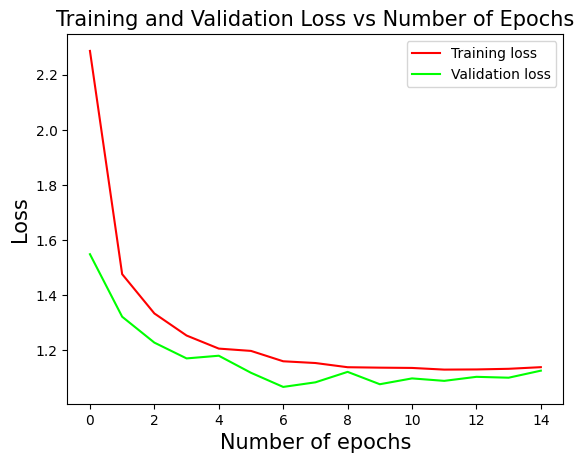

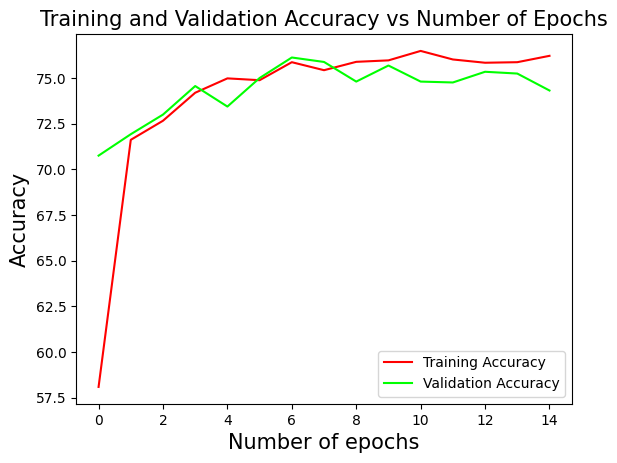

Training complete in 44m 48s
Best val Acc: 76.123047


In [13]:
model = train(model,loss_fun, optimizer,lr_scheduler, num_epoch)